**New Reward Function:**
- If $|r_{actual} - r_{target}| < α$ where I chose $α = 0.05$ then $r_{dist} = 0$
- Else: $r_{dist} = |r_{actual} - r_{target}| \times (1 + \frac{t}{β})$ where $β = 256$

This means that the model does not need to overcontrol to correct any $r_{error} < α$ and additionally that the penalty for $r_{error}$ rises by a factor of $\frac{1}{β} ≈ 0.00036$ per timestep or roughly $\times 99$ (as $\frac{25000}{256}\approx 98$) at $t=25000$. Therefore at $t=25000$ any $r_{error} > \frac{1}{99 w_r} \approx 0.1$ gets 0 reward. Meaning at $(t=0, r=4)$ the $r_{error}\approx 0.3$ while at $(t=25000, r=4)$ the $r_{error} \approx 30$

This can be applied to the momentum as well.

**New Breakdown of Model Performance by $r_0$ when Training**

Plugged in a function from the `pprint()` library which will allow us to, when collecting the (time survived, reward of final timestep, final radius, and final cumulative thrust) print out how that observation looked at every starting radius which was tested over that training period.



In [8]:
import torch
import numpy as np

import gym
import itertools
import statistics
import statsmodels.api as sm
from itertools import accumulate
from datetime import datetime, timedelta

import pprint
import plotly.io as pio
import plotly.express as px
import plotly.graph_objs as go

import os
import glob
import time
import concurrent.futures
from datetime import datetime

import torch
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
from matplotlib.patches import FancyArrowPatch as Arrow
from typing import Any, List, Sequence, Tuple

import math
import tensorflow as tf
from typing import Optional, Union

import gym
from gym import logger, spaces
from gym.envs.classic_control import utils
from gym.error import DependencyNotInstalled

import torch
import torch.nn as nn
from torch.autograd import Function
from torch.distributions import MultivariateNormal
from torch.distributions import Categorical

from IPython.display import HTML
from base64 import b64encode
from typing import Any, List, Sequence, Tuple

# matplotlib.use('TkAgg')

class RocketAnimation(object):
    def __init__(self, r_min=0.1, r_target=1, r_max=10, xlim=(-10.2, 10.2), ylim=(-10.2, 10.2), markersize=10, circle_alpha=1, t_vec_len=1):
        self.r_min = r_min
        self.r_target = r_target
        self.r_max = r_max

        self.marker_size = markersize
        self.circle_alpha = circle_alpha
        self.t_vec_len = t_vec_len

        self.states = list()
        self.thrusts = list()
        self.requested_thrusts = list()
        self.theta_dot = list()

        self.rewards = list()
        self.action = list()

        self.rmin = list()
        self.rtarget = list()
        self.rmax = list()

        self.xlim = xlim
        self.ylim = ylim

    def _circle(self, radius):
        theta = np.linspace(0, 2 * np.pi, 100)
        x, y = radius * np.cos(theta), radius * np.sin(theta)
        return x, y

    def _init(self,):
        self.ax.clear()

        self.arrow = Arrow(posA=(0, 0), posB=(0, 0), arrowstyle='simple', mutation_scale=5, color='r')
        self.ax.add_patch(self.arrow)
        self.line, = self.ax.plot([], [], marker='o', markersize=self.marker_size, alpha=self.circle_alpha)
        self.min_circle, = self.ax.plot(*self._circle(self.r_min), '--', label='Minimum Radius')
        #self.start_circle, = self.ax.plot(*self._circle(self.r_start), '--', label='Starting Orbit', color='tab:orange') ##### TARGET = 0.3
        self.target_circle, = self.ax.plot(*self._circle(self.r_target), '--', label='Target Orbit')
        self.max_circle, = self.ax.plot(*self._circle(self.r_max), '--', label='Maximum Radius')
        self.ax.grid(True)
        self.ax.legend(loc='upper left')
        return self.line, self.min_circle, self.target_circle, self.max_circle

    def _animate(self, i):
        st = self.states[i]
        vec = self.thrusts[i] * self.t_vec_len * (self.xlim[1] - self.xlim[0])

        self.line.set_data([st[0]], [st[1]])
        self.min_circle.set_data(*self._circle(self.rmin[i]))
        self.target_circle.set_data(*self._circle(self.rtarget[i]))
        self.max_circle.set_data(*self._circle(self.rmax[i]))

        self.arrow.set_positions(posA=st[:2], posB=st[:2] + vec)
        self.fig.suptitle(f'Iteration: {i}')
        return self.line, self.min_circle, self.target_circle, self.max_circle

    def save_animation(self, name):
        self._transform_vectors()
        self.fig = plt.figure(figsize=(10, 10), num=1,
                              clear=True, tight_layout=True)
        self.ax = self.fig.add_subplot(111)
        anim = FuncAnimation(self.fig, self._animate, init_func=self._init, frames=len(
            self.states), blit=True, interval=100, repeat=False)
        anim.save(name, dpi=80)

    def summary_plot(self):
        self._transform_vectors()
        self.fig1 = plt.figure(figsize=(10, 12), num=1,
                              clear=True, tight_layout=True)
        ax1 = self.fig1.add_subplot(611)
        ax2 = self.fig1.add_subplot(612)
        ax3 = self.fig1.add_subplot(613)
        ax4 = self.fig1.add_subplot(614)
        ax5 = self.fig1.add_subplot(615)
        ax6 = self.fig1.add_subplot(616)

        self.fig1.suptitle('Run Summary')

        # Plot Thrust Value
        ax1.set_title('Thrust Values')
        ax1.plot([thrust[1] for thrust in self.thrusts_polar], label='thrust tangent')
        ax1.grid(True)
        ax1.legend()

        # Plot Theta Dot
        ax2.set_title('theta_dot')
        ax2.plot([theta for theta in self.theta_dot], label='theta_dot')
        ax2.grid(True)
        ax2.legend()

        # Plot Radius
        ax3.set_title('Radius')
        ax3.plot(self.rs, label='radius')
        ax3.grid(True)
        ax3.legend()

        # Plot Velocities
        ax4.set_title('Radial Velocities')
        ax4.plot([vel[0] for vel in self.vel_polar], label='radial velocity')
        ax4.grid(True)
        ax4.legend()

        # Tangential Velocities
        ax5.set_title("Tangential Velocities")
        ax5.plot([vel[1] for vel in self.vel_polar], label='tangential velocity')
        ax5.grid(True)
        ax5.legend()

        # Plot Cumulative Thrust
        ax6.set_title("Cumulative Thrust")
        ax6.plot(list(accumulate(self.thrusts_polar, lambda x, thrust: x + thrust[0], initial=0))[1:], label='cumulative thrust')
        ax6.grid(True)
        ax6.legend()

        self.fig1.tight_layout()
        return self.fig1

    def get_run_info(self):
      self._transform_vectors()
      return [[thrust[1] for thrust in self.thrusts_polar],
              [theta for theta in self.theta_dot],
              self.rs,
              [vel[0] for vel in self.vel_polar],
              [vel[1] for vel in self.vel_polar]]

    def _get_transforms(self, states):
        transforms = list()
        rs = list()
        thetas = list()

        for st in states:
            pos, vel = st[:2], st[2:]
            r = np.linalg.norm(pos)
            theta = np.arctan2(pos[1], pos[0])
            rhat = pos / r

            rot_mat = np.array([[rhat[0], -rhat[1]], [rhat[1], rhat[0]]])
            transforms.append(rot_mat)
            rs.append(r)
            thetas.append(theta)

        return transforms, rs, thetas

    def _forward_transform(self, transforms, vecs):
        return [tr @ vec for tr, vec in zip(transforms, vecs)]

    def _inverse_transform(self, transforms, vecs):
        return [tr.T @ vec for tr, vec in zip(transforms, vecs)]


    def _transform_vectors(self, ):
        transforms, self.rs, self.thetas = self._get_transforms(self.states)
        self.vel_polar = self._inverse_transform(
            transforms, [st[2:] for st in self.states])
        self.thrusts_polar = self._inverse_transform(transforms, self.thrusts)
        self.requested_thrusts_polar = self._inverse_transform(
            transforms, self.requested_thrusts)
        self.theta_dot = [v_tangential / r if r != 0 else 0 for v_tangential, r in zip([vel[1] for vel in self.vel_polar], self.rs)]
        self.thrusts_norm = [np.linalg.norm(thrust) for thrust in self.thrusts]
        self.requested_thrusts_norm = [np.linalg.norm(
            thrust) for thrust in self.requested_thrusts]
        self.thrust_direction = [np.arctan2(
            thrust[1], thrust[0]) for thrust in self.thrusts_polar]
        self.requested_thrust_direction = [np.arctan2(
            thrust[1], thrust[0]) for thrust in self.requested_thrusts_polar]

    def render(self, state, thrust, requested_thrust, rmin, rtarget, rmax):
        self.states.append(state)
        self.thrusts.append(thrust)
        self.requested_thrusts.append(requested_thrust)
        self.rmin.append(rmin)
        self.rtarget.append(rtarget)
        self.rmax.append(rmax)

    def return_arrays(self):
      return self.states, self.thrusts

def show_video(video_path, video_width = 600):
  video_file = open(video_path, "r+b").read()
  video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
  return HTML(f"""<video width={video_width} controls><source src="{video_url}"></video>""")

device = torch.device('cpu')
if(torch.cuda.is_available()):
    device = torch.device('cuda:0')
    torch.cuda.empty_cache()
    print("Device set to : " + str(torch.cuda.get_device_name(device)))
else:
    print("Device set to : cpu")


################################## PPO Policy ##################################
class RolloutBuffer:
    def __init__(self):
        self.actions = []
        self.states = []
        self.logprobs = []
        self.rewards = []
        self.state_values = []
        self.is_terminals = []
        self.ep_done = []

    def clear(self):
        del self.actions[:]
        del self.states[:]
        del self.logprobs[:]
        del self.rewards[:]
        del self.state_values[:]
        del self.is_terminals[:]
        del self.ep_done[:]

# It's very similar to the initial actor critic class implemented above

class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim, has_continuous_action_space, action_std_init):
        super(ActorCritic, self).__init__()
        #In this section I'm only interested in the continous space
        self.has_continuous_action_space = has_continuous_action_space

        if has_continuous_action_space:
            self.action_dim = action_dim
            self.action_var = torch.full((action_dim,), action_std_init * action_std_init).to(device)

        # actor
        #I'm mainly going to keep the same dimensions as the ones used above
        if has_continuous_action_space :
            self.actor = nn.Sequential(
                            nn.Linear(state_dim, 12),
                            nn.LeakyReLU(),
                            nn.Linear(12, 12),
                            nn.LeakyReLU(),
                            nn.Linear(12, 12),
                            nn.LeakyReLU(),
                            nn.Linear(12, 12),
                            nn.LeakyReLU(),
                            nn.Linear(12, action_dim),
                            nn.Tanh()
                        )
            #the use of tanh here maps the actions in the range -1 / 1.
        else:
            self.actor = nn.Sequential(
                            nn.Linear(state_dim, 12),
                            nn.LeakyReLU(),
                            nn.Linear(12, 12),
                            nn.LeakyReLU(),
                            nn.Linear(12, 12),
                            nn.LeakyReLU(),
                            nn.Linear(12, 12),
                            nn.Tanh(),
                            nn.Linear(12, action_dim),
                            nn.Softmax(dim=-1)
                        )
            # the use of softmax if it's not continous gives for each action, a probability associated.
        # critic
        self.critic = nn.Sequential(
                        nn.Linear(state_dim, 12),
                        nn.Tanh(),
                        nn.Linear(12, 12),
                        nn.Tanh(),
                        nn.Linear(12, 12),
                        nn.Tanh(),
                        nn.Linear(12, 12),
                        nn.Tanh(),
                        nn.Linear(12, 1)
                    )
        # The use of tanh as an activation function here prevents a gradient
        #explosion by keeping in between the layers the values between -1/1


    def set_action_std(self, new_action_std):
        if self.has_continuous_action_space:
            self.action_var = torch.full((self.action_dim,), new_action_std * new_action_std).to(device)


    # This function is used during the interaction phase, where the agent interacts with the environment to collect experiences.
    def act(self, state, min, max):
        # the continous action
        if self.has_continuous_action_space:
          #so the actor has as a purpose to give off the meand of the action explaining even more the use of tanh
            action_mean = self.actor(state)
            # so that's where we aff the varience to it
            cov_mat = torch.diag(self.action_var).unsqueeze(dim=0)
            # This creqtes the multivavariate normal distribution with the specified mean and cov_mat
            dist = MultivariateNormal(action_mean, cov_mat)
        else:
            action_probs = self.actor(state)
            dist = Categorical(action_probs)
        # It samples from the distribution the action
        action = dist.sample()
        #print("action before clamp",action)
        #action = torch.clip(action,min,max) #ensures that the action is between a specific range.
        #print("action after clamp", action)
        action_logprob = dist.log_prob(action)
        state_val = self.critic(state)

        return action.detach(), action_logprob.detach(), state_val.detach()

  # This function is used during the training phase
    def evaluate(self, state, action):

        if self.has_continuous_action_space:

            action_mean = self.actor(state)
            action_var = self.action_var.expand_as(action_mean)
            cov_mat = torch.diag_embed(action_var).to(device)
            dist = MultivariateNormal(action_mean, cov_mat)

            # For Single Action Environments.(which is our situation here)
            if self.action_dim == 1:
                action = action.reshape(-1, self.action_dim)
        else:
            action_probs = self.actor(state)
            dist = Categorical(action_probs)
        action_logprobs = dist.log_prob(action)
        dist_entropy = dist.entropy()
        state_values = self.critic(state)

        return action_logprobs, state_values, dist_entropy

class PPO:
    def __init__(self, state_dim, action_dim, lr_actor, lr_critic, gamma, K_epochs, eps_clip, has_continuous_action_space=True, action_std_init=0.6):

        self.has_continuous_action_space = has_continuous_action_space

        if has_continuous_action_space:
            self.action_std = action_std_init

        self.gamma = gamma # discount factor
        self.eps_clip = eps_clip
        self.K_epochs = K_epochs
        self.buffer = RolloutBuffer()
        self.policy = ActorCritic(state_dim, action_dim, has_continuous_action_space, action_std_init).to(device)
        self.optimizer = torch.optim.Adam([
                        {'params': self.policy.actor.parameters(), 'lr': lr_actor},
                        {'params': self.policy.critic.parameters(), 'lr': lr_critic}
                    ]) #specific learning rate for the actor and for the critic

        self.policy_old = ActorCritic(state_dim, action_dim, has_continuous_action_space, action_std_init).to(device) #I'm wondering if this line is actually necessary
        self.policy_old.load_state_dict(self.policy.state_dict()) # apparently that copies the weights of the policy dict so that it starts at the same point, before any update is being made.

        self.MseLoss = nn.MSELoss()

    def set_action_std(self, new_action_std):
        if self.has_continuous_action_space:
            self.action_std = new_action_std
            self.policy.set_action_std(new_action_std)
            self.policy_old.set_action_std(new_action_std)

#we decay the standard deviation in order to have a more norrow down possible actions to take so more exploitation and less exploration.
    def decay_action_std(self, action_std_decay_rate, min_action_std):
        if self.has_continuous_action_space:
            self.action_std = self.action_std - action_std_decay_rate
            self.action_std = round(self.action_std, 4)
            if (self.action_std <= min_action_std):
                self.action_std = min_action_std
            self.set_action_std(self.action_std)

    def select_action(self, state, min , max):
        #print("It's getting there")
        if self.has_continuous_action_space:
            with torch.no_grad():
                #print("before state")
                state = torch.FloatTensor(state).to(device)
                #print("before policy_old.act")
                action, action_logprob, state_val = self.policy_old.act(state, min, max)
                #print("action in select_action", action)# so it's the old policy that acts. Because it's the previous policy that has been updated from the previous update but hasn't acted yet
            #print("action ",action, " action_logprob ", action_logprob, " state_val ",state_val)
            #print("the buffer will get updated")
            self.buffer.states.append(state)
            self.buffer.actions.append(action)
            self.buffer.logprobs.append(action_logprob)
            self.buffer.state_values.append(state_val)
            #print("the buffer got updated")

            return action.detach().cpu().numpy().flatten()
        else:
            with torch.no_grad():
                state = torch.FloatTensor(state).to(device)
                action, action_logprob, state_val = self.policy_old.act(state)

            self.buffer.states.append(state)
            self.buffer.actions.append(action)
            self.buffer.logprobs.append(action_logprob)
            self.buffer.state_values.append(state_val)

            return action.item()

    def update(self):
        '''
        The update function, called when update_timestep is reached and the episode is done
        It starts by calculating the discounted reward and uses a geometric sum if the episode ended because it reached the maximum timestep
        The normalisation also had been deleted as the number it got normalized to were somehow questionable
        '''
        good_episode = False # this boolean helps determining if the episode ended because it reached the maximum number of steps
        good_episode_reward = 0 # this allows to substract the right reward every time
        rewards = [] # discounted reward array
        discounted_reward = 0

        for reward, is_terminal, ep_done in zip(reversed(self.buffer.rewards), reversed(self.buffer.is_terminals), reversed(self.buffer.ep_done)): #This is basically doing with a for loop what my discount function was doing

            if is_terminal: # that will be true no matter how the episode ended when an episode ended
                discounted_reward = 0 # reseting the discounted reward
                good_episode = False # reseting the boolean to false

            if ep_done : # that will be true if the episode ended because it reached the maximum number of stps
                discouted_reward = reward * (self.gamma**800 - 1)/(self.gamma -1) # geometric serie
                good_episode_reward = reward
                good_episode = True

            if good_episode : # it will be true for the entirety of the "good episode"
              discounted_reward = reward + (self.gamma* discounted_reward) - good_episode_reward*self.gamma**800


            else : # the episode ended because it reached a bound
              discounted_reward = reward + (self.gamma * discounted_reward) # how it was originaly computed !

            rewards.insert(0, discounted_reward)

        ############################ END OF THE MAIN CHANGES ###################

        # Normalizing the rewards (LET'S TRY THAT )
        #print("at the end of the loop the discounted reward array was :",rewards)
        rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
        rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-7)

        # convert list to tensor
        old_states = torch.squeeze(torch.stack(self.buffer.states, dim=0)).detach().to(device)
        old_actions = torch.squeeze(torch.stack(self.buffer.actions, dim=0)).detach().to(device)
        old_logprobs = torch.squeeze(torch.stack(self.buffer.logprobs, dim=0)).detach().to(device)
        old_state_values = torch.squeeze(torch.stack(self.buffer.state_values, dim=0)).detach().to(device)

        # calculate advantages
        advantages = rewards.detach() - old_state_values.detach()

        # Optimize policy for K epochs
        for _ in range(self.K_epochs):

            # Evaluating old actions and values
            logprobs, state_values, dist_entropy = self.policy.evaluate(old_states, old_actions) # I'm confused because I don't really see where we precviously update the policy ...

            # match state_values tensor dimensions with rewards tensor
            state_values = torch.squeeze(state_values)

            # Finding the ratio (pi_theta / pi_theta__old)
            ratios = torch.exp(logprobs - old_logprobs.detach())

            # Finding Surrogate Loss
            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1-self.eps_clip, 1+self.eps_clip) * advantages

            # final loss of clipped objective PPO
            loss = -torch.min(surr1, surr2) + 0.5 * self.MseLoss(state_values, rewards) - 0.01 * dist_entropy

            # take gradient step
            self.optimizer.zero_grad() # In the initialization we're linking the optimizer to self.policy (update comes partially from here)
            loss.mean().backward()
            self.optimizer.step()

        # Copy new weights into old policy
        self.policy_old.load_state_dict(self.policy.state_dict())

        # clear buffer
        self.buffer.clear()


    def save(self, checkpoint_path):
        torch.save(self.policy_old.state_dict(), checkpoint_path)

    def load(self, checkpoint_path):
        self.policy_old.load_state_dict(torch.load(checkpoint_path, map_location=lambda storage, loc: storage))
        self.policy.load_state_dict(torch.load(checkpoint_path, map_location=lambda storage, loc: storage))

import gym
from gym.spaces import Box
from gym.utils import seeding

import numpy as np
import matplotlib.pyplot as plt

from logging import raiseExceptions
from typing import (
    Any, Generic, Iterable, List, Mapping, Optional, Sequence, Tuple, Type,
    TypeVar, Union, Dict, Callable
)

## I deleted from animation in order ton use the animation I have in the notebook
## Adding a continous episode option
def make(name):
    if name == 'RocketCircularization-v0':
        init_func = varied_l(r_min=0.5, r_max=1.5)
        return RocketEnv(max_step=400, simulation_step=3, rmax=1.5, rmin=0.5,
                         init_func=init_func, max_thrust=.1,
                         oob_penalty=0, dt=0.03, wall_mechanics=True,
                         velocity_penalty_rate=0.1, thrust_penalty_rate=0.001)
    else:
        raise ValueError(f'No environment {name}')

def uniform(r_min: float = 0.99, r_max: float = 1.01,
            rdot_min: float = -0.05, rdot_max: float = 0.05,
            thetadot_min: float = 0.99, thetadot_max: float = 1.01) \
        -> Callable[[], List[np.float32]]:
    def func():
        nonlocal r_min, r_max, rdot_min, rdot_max, thetadot_min, thetadot_max
        r = np.random.uniform(r_min, r_max)
        theta = np.random.uniform(0, 2 * np.pi)
        rdot = np.random.uniform(rdot_min, rdot_max)
        thetadot = np.random.uniform(thetadot_min, thetadot_max)
        pos = [r, 0]
        vel = [rdot, r * thetadot]
        rot_mat = np.array([[np.cos(theta), -np.sin(theta)],
                            [np.sin(theta), np.cos(theta)]])
        return [*(rot_mat @ pos), *(rot_mat @ vel)]
    return func

def varied_l(r_min: float = 0.9, r_max: float = 1.1,
             rdot_min: float = -0.5, rdot_max: float = 0.5,
             dl_min: float = -.5, dl_max: float = .5) \
        -> Callable[[], List[np.float32]]:
    def func():
        nonlocal r_min, r_max, rdot_min, rdot_max
        r = np.random.uniform(r_min, r_max)
        theta = np.random.uniform(0, 2 * np.pi)
        rdot = np.random.uniform(rdot_min, rdot_max)
        thetadot = (1 + np.random.uniform(dl_min, dl_max)) / r ** 2
        pos = [r, 0]
        vel = [rdot, r * thetadot]
        rot_mat = np.array([[np.cos(theta), -np.sin(theta)],
                            [np.sin(theta), np.cos(theta)]])
        return [*(rot_mat @ pos), *(rot_mat @ vel)]
    return func

def target_l(r_min: float = 0.5, r_max: float = 1.5,
             rdot_min: float = -0.5, rdot_max: float = 0.5) \
        -> Callable[[], List[np.float32]]:
    def func():
        nonlocal r_min, r_max, rdot_min, rdot_max
        r = np.random.uniform(r_min, r_max)
        theta = np.random.uniform(0, 2 * np.pi)
        rdot = np.random.uniform(rdot_min, rdot_max)
        thetadot = 1 / r ** 2
        pos = [r, 0]
        vel = [rdot, r * thetadot]
        rot_mat = np.array([[np.cos(theta), -np.sin(theta)],
                            [np.sin(theta), np.cos(theta)]])
        return [*(rot_mat @ pos), *(rot_mat @ vel)]
    return func

def testing_1() -> Callable[[], List[np.float32]]:
  def func():
    r = 1
    theta = np.random.uniform(0, 2 * np.pi)
    rdot = 0
    thetadot = 1
    pos = [r, 0]
    vel = [rdot, r * thetadot]
    rot_mat = np.array([[np.cos(theta), -np.sin(theta)],
                            [np.sin(theta), np.cos(theta)]])
    return [*(rot_mat @ pos), *(rot_mat @ vel)]
  return func

def orbit1_1() -> Callable[[], List[np.float32]]:
  def func():
    r = 1.1
    theta = np.random.uniform(0, 2 * np.pi)
    rdot = 0
    thetadot = 0.9535
    pos = [r, 0]
    vel = [rdot, r * thetadot]
    rot_mat = np.array([[np.cos(theta), -np.sin(theta)],
                              [np.sin(theta), np.cos(theta)]])
    return [*(rot_mat @ pos), *(rot_mat @ vel)]
  return func


# FIRST MODIFICATION : CHANGE OF THE QUADRATIC PENALTY

def quadratic_penalty(iters, state: np.ndarray, action: np.ndarray, r_target: float =1, cum_thrust: float = 0,
                      w_r: float=1, w_p :float =1,w_t :float =0.5, w_c: float = 0.0001,
                      G: float = 1, M: float = 1,mode: str = 'abs') -> np.float32:
    vtarget = np.sqrt(G * M / r_target)
    r, v = state[:2], state[2:]
    dist = np.linalg.norm(r)
    rhat = r / dist
    rotation_matrix = np.array([[rhat[0], rhat[1]], [-rhat[1], rhat[0]]])
    vpolar = rotation_matrix @ v
    if mode == 'squared' :
      quadratic = w_r*(dist - r_target)**2 + w_p*(vpolar[1]*dist -vtarget*r_target)**2 + w_t*(np.linalg.norm(action))**2
    elif mode == 'abs' :
      r_dist = 0 if abs(dist - r_target) < 0.05 else abs(dist - r_target)*(1+(iters/256))
      mom_dist = 0 if abs(vpolar[1]*dist -vtarget*r_target) < 0.05 else abs(vpolar[1]*dist -vtarget*r_target)*(1+(iters/256))
      cum_thrust = 0 if cum_thrust < 10 else cum_thrust
      quadratic = w_r*r_dist + w_p*mom_dist + w_c*cum_thrust
      #print(f"{quadratic}\t\t{w_r*r_dist}\t{ w_p*mom_dist}\t{w_t*abs(np.linalg.norm(action))}\t{w_c*cum_thrust}")

    #   if dist==4.0 or dist==0.1:
    #     print(f"{dist}--- {r_dist}\t{mom_dist}\t{np.linalg.norm(action)}\t{cum_thrust}")
    #   elif quadratic > 1:
    #     print(f"{dist}--- {r_dist}\t{mom_dist}\t{np.linalg.norm(action)}\t{cum_thrust}")

    return quadratic


# SAME HERE (type of reward function ?)
def clip_by_norm(t: np.ndarray, mins: float, maxs: float) -> np.ndarray:
    norm = np.linalg.norm(t)
    if np.count_nonzero(t) == 0 and mins > 0:
        raise ValueError('Trying to clip norm of zero vector')
    if norm < mins:
        t = t * mins / norm
    elif norm > maxs:
        t = t * maxs / norm

    return t

def reward_function(iters, state: np.ndarray, action: np.ndarray, rtarget: float, cum_thrust: float,
                    w_r: float=1, w_p :float =1,w_t :float =1, w_c: float = 0.0001,
                    mode: str = 'Log_10', min :float = 0, max :float = 4, G: float = 1, M: float = 1) -> np.float32:
    value = quadratic_penalty(iters, state, action, rtarget, cum_thrust, w_r,w_p,w_t,w_c, G, M)

    if mode == 'Quadratic':
        return value
    elif mode == 'Log_10':
        #print(np.clip(-np.log10(value),min,max))
        return np.clip(-np.log10(value),min,max)
    elif mode == 'Ln' :
        return np.clip(-np.log(value),min,max)
    elif mode ==  'Inverse' :
        return np.clip(1/(value), min, max)
    else:
        ValueError(f'Invalid reward mode {mode}')

class RocketEnv(gym.Env):
    def __init__(self,
                 G: float = 1, M: float = 1, m: float = .01, dt: float = .01,
                 rmin: float = .1, rmax: float = 2, rtarget: float = 1, vmax: float = 10,
                 w_r:float = 1, w_p:float =1, w_t: float=1, w_c: float = 0.0001, mode: str = 'Log_10',
                 init_func: Callable[[], np.ndarray] = varied_l(),
                 oob_penalty: float = 10, max_thrust: float = .1, clip_thrust: str = 'Ball',
                 max_step: int = 500, simulation_step: int = 1) -> None:
        super().__init__()

        #print("It is my environment that is running")
        self.observation_space = Box(low=np.array([-rmax, -rmax, -vmax, -vmax]),
                                     high=np.array([rmax, rmax, vmax, vmax]),
                                     shape=(4, ), dtype=np.float32)
        self.action_space = Box(low=np.array([-max_thrust, -max_thrust]),
                                high=np.array([max_thrust, max_thrust]),
                                shape=(2, ), dtype=np.float32)

        self.G, self.M, self.m, self.dt = G, M, m, dt
        self.rmin, self.rmax, self.rtarget = rmin, rmax, rtarget
        self.vmax = vmax
        self.oob_penalty = oob_penalty
        self.max_thrust = max_thrust
        self.min_action = -self.max_thrust
        self.max_action = self.max_thrust
        self.clip_thrust = clip_thrust
        self.init_func = init_func
        self.w_r = w_r
        self.w_p = w_p
        self.w_t = w_t
        self.w_c = w_c
        self.mode = mode
        self.max_step, self.simulation_step = max_step, simulation_step
        self.iters = 0

        #things to visualise what's happening
        self.reward = 0
        self.number_action = 0


        # Animation object
        lim = rmax * 1.1
        self.animation = RocketAnimation(r_min=rmin, r_target=rtarget, r_max=rmax, xlim=(-lim, lim), ylim=(-lim, lim),
                                         markersize=10, circle_alpha=1, t_vec_len=.1)
        self.cum_thrust = 0

    def reset(self, seed: Optional[int] = None,
              return_info: bool = False,
              options: Optional[dict] = None) -> Union[np.ndarray, Tuple[np.ndarray, dict]]:
        super().reset(seed=seed)

        if options is not None and 'init_func' in options:
            init_func = options['init_f   unc']
        else:
            init_func = self.init_func

        self.state = np.array(init_func())
        self.init_state = self.state
        self.iters = 0
        self.prev_score = - \
            np.abs(self.rmax - self.rtarget) - \
            self.w_p * 2 * self.vmax
        self.done = False
        self.ep_done = False
        self.cum_thrust = 0
        self.last_action = np.array([0, 0])
        lim = self.rmax * 1.1
        if return_info:
            return self.state, dict()
        else:
            return self.state

    # CHANGES IN STEP IN ORDERN TO MAKE IT DISCOUNTINOUS :

    def step(self, action: np.ndarray) -> Union[Tuple[np.ndarray, float, bool, bool, dict],
                                                Tuple[np.ndarray, float, bool, dict]]:
        if self.done:
            print('Warning: Stepping after done is True')
        action = np.array(action)
        self.last_action = action
        if self.clip_thrust == 'Box':
            action = np.clip(action, -1, 1)
        elif self.clip_thrust == 'Ball':
            magnitude = np.linalg.norm(action)
            if magnitude > 1:
                action = action / magnitude
        elif self.clip_thrust == 'None':
            pass
        else:
            raise ValueError(
                f'Thrust clipping mode {self.clip_thrust} does not exist')
        r, v = self.state[:2], self.state[2:]
        reward = 0
        info = dict()
        self.cum_thrust += np.abs(action[0])

        # SIMULATING STEPS
        for _ in range(self.simulation_step):
            gravitational_force = - (self.G * self.M * self.m) / \
                (np.power(np.linalg.norm(r), 3)) * r  # F = - GMm/|r|^3 * r
            thrust_force = action * self.m * self.max_thrust
            total_force = gravitational_force + thrust_force
            v = v + total_force / self.m * self.dt
            r = r + v * self.dt
            self.done = bool(
                  np.linalg.norm(r) < self.rmin
                  or np.linalg.norm(r) > self.rmax
              )
            if self.done :
              break
            reward += reward_function(self.iters, np.array([*r,*v]),action,self.rtarget,self.cum_thrust,
                                      w_r = self.w_r, w_p= self.w_p, w_t = self.w_t, w_c = self.w_c,
                                      mode = self.mode)
        self.reward = reward
        self.state = np.array([*r, *v])
        self.iters += 1
        if self.iters >= self.max_step:
            self.ep_done = True
            self.done = True
        return self.state, self.reward, self.done, self.ep_done, info

    def render(self, *args: Tuple[Any], **kwargs: Dict[str, Any]) -> None:
        self.animation.render(self.state, self.last_action, self.last_action,
                              self.rmin, self.rtarget, self.rmax)

    def show(self, path: Optional[str] = None, summary: bool = False) -> None:
        if path is None:
            path = "path.mp4"
        self.animation.save_animation(path)
        return path

    def get_run_info(self):
        return self.animation.get_run_info()

##  MY WRAPPER ##
class CTangentialThrust(gym.ActionWrapper):
    '''
    Wrapper for RocketEnv. Provides continous ranges for thrust vectors in the tangential direction
    with unit length. Note that it needs to be used in conjuction with PolarizeAction for
    the thrust values to point in the tangential direction.
    '''

    def __init__(self, env: gym.Env):
        super().__init__(env)
        self.action_space = gym.spaces.Box(low=-self.max_thrust, high= self.max_thrust, shape = (1,), dtype= np.float32)

    def action(self, action):
        #print("It gets there ")
        #print(action)
        action = action[0].item()
        #print("here the action is", action)
        self.number_action = action
        action = np.array([0,action])
        #print(" the polar action should be :", action)
        state = self.unwrapped.state
        #print(" In order to verify manually : the current state is", state)
        r, v = state[:2], state[2:]
        dist = np.linalg.norm(r)
        rhat = r / dist
        rotation_matrix = np.array([[rhat[0], -rhat[1]], [rhat[1], rhat[0]]])
        action = rotation_matrix @ action
        #print(" The cartesian coordinate action is ", action)
        return action

class PolarizeObservation(gym.ObservationWrapper):
    def __init__(self, env: gym.Env) -> None:
        super().__init__(env)

    def observation(self, obs: np.ndarray) -> np.ndarray:
        r, v = obs[:2], obs[2:]
        dist = np.linalg.norm(r)
        rhat = r / dist
        rotation_matrix = np.array([[rhat[0], rhat[1]], [-rhat[1], rhat[0]]])
        obs = np.array([dist, *(rotation_matrix @ v)])
        return obs


def show_video(video_path, video_width = 500):
  video_file = open(video_path, "r+b").read()
  video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
  return HTML(f"""<video width={video_width} controls><source src="{video_url}"></video>""")

def orbit(r) -> Callable[[], List[np.float32]]:
  def func():
    theta = np.random.uniform(0, 2 * np.pi)
    rdot = 0
    v_dot = 1 / np.sqrt(r)

    pos = [r, 0]
    vel = [rdot, v_dot]
    rot_mat = np.array([[np.cos(theta), -np.sin(theta)],
                              [np.sin(theta), np.cos(theta)]])
    return [*(rot_mat @ pos), *(rot_mat @ vel)]
  return func

def get_plots(env, r_init, r_target, max_len, max_steps, rmax, rmin, w_r, w_p, w_t, max_thrust, dt, show_both=False, target_thrust_bound=50e-6, overlap_bound=1e-2):
    def make(name):
        init_func = orbit(r_init)
        return RocketEnv(max_step=max_steps, simulation_step=1, rmax=rmax, rmin=rmin,
                w_r = w_r , w_p = w_p, w_t = w_t,
                mode = "Ln", init_func=init_func,
                max_thrust=max_thrust, oob_penalty=0, dt=dt)
    env2 = make('RocketCircularization-v1')
    env2.seed()
    env2 = PolarizeObservation(env2)
    env2 = CTangentialThrust(env2)

    def needed_delta_v(env2, tan_vel, r_init, r_target, init):
        GM = env2.G * env2.M
        if init: # At r_init
          return math.sqrt(GM / r_init) * (math.sqrt(2 * r_target / (r_init + r_target)) - 1)
        else: # At r_final
          return math.sqrt(GM / r_target) * (1 - math.sqrt(2 * r_init / (r_init + r_target)))

    state = env2.reset()
    r_init = state[0]
    r_target = 1.0
    done = False
    fired_1 = False
    fired_2 = False
    i = 0

    while not done:
        env2.render()
        if np.abs(r_init-r_target) < overlap_bound:
          state, reward, done, _, _ = env2.step(torch.tensor([0]))
        elif state[0]==r_init and not fired_1:
          tan_vel = state[2]
          delta_v = needed_delta_v(env2, tan_vel, r_init, r_target, True)
          state, reward, done, _, _ = env2.step(torch.tensor([delta_v]))
          fired_1 = True
        elif np.abs(state[0]-r_target) < target_thrust_bound and not fired_2:
          tan_vel = state[2]
          delta_v = needed_delta_v(env2, tan_vel, r_init, r_target, False)
          state, reward, done, _, _ = env2.step(torch.tensor([delta_v]))
          fired_2 = True
        else:
          state, reward, done, _, _ = env2.step(torch.tensor([0]))
        i += 1
        done = done or i == max_len

    original_thrusts, original_theta_dots, original_radii, original_radial_vels, original_tang_vels = env.get_run_info()
    thrusts, theta_dots, radii, radial_vels, tang_vels = env2.get_run_info()
    fig1 = plt.figure(figsize=(10, 12), num=1,
                          clear=True, tight_layout=True)
    ax1 = fig1.add_subplot(611)
    ax2 = fig1.add_subplot(612)
    ax3 = fig1.add_subplot(613)
    ax4 = fig1.add_subplot(614)
    ax5 = fig1.add_subplot(615)
    ax6 = fig1.add_subplot(616)

    # Plot Thrust Value
    ax1.set_title('Thrust Values')
    ax1.plot(original_thrusts, label='Model', color='turquoise')
    ax1.plot(thrusts, label='Hohmann estimate', color='royalblue')
    ax1.grid(True)
    ax1.legend()

    # Plot Radius
    ax2.set_title('Radius')
    ax2.plot(original_radii, label='Model', color='turquoise')
    ax2.plot(radii, label='Hohmann estimate', color='royalblue')
    ax2.grid(True)
    ax2.legend()

    # Tangential Velocities
    ax3.set_title("Tangential Velocities")
    ax3.plot(original_tang_vels, label='Model', color='turquoise')
    ax3.plot(tang_vels, label='Hohmann estimate', color='royalblue')
    ax3.grid(True)
    ax3.legend()

    # Plot Cumulative Thrust

    original_cum_thrusts = list(accumulate(original_thrusts, lambda x, y: x + np.abs(y), initial=0))[1:]
    cum_thrusts = list(accumulate(thrusts, lambda x, y: x + np.abs(y), initial=0))[1:]

    ax4.set_title("Cumulative Thrust")
    ax4.plot(original_cum_thrusts, label='Model', color='turquoise')
    ax4.plot(cum_thrusts, label='Hohmann estimate', color='royalblue')
    ax4.grid(True)
    ax4.legend()

    # Plot Velocities
    ax5.set_title('Radial Velocities')
    ax5.plot(original_radial_vels, label='Model', color='turquoise')
    ax5.plot(radial_vels, label='Hohmann estimate', color='royalblue')
    ax5.grid(True)
    ax5.legend()

    # Plot Theta Dot
    ax6.set_title('theta_dot')
    ax6.plot(original_theta_dots, label='Model', color='turquoise')
    ax6.plot(theta_dots, label='Hohmann estimate', color='royalblue')
    ax6.grid(True)
    ax6.legend()

    fig1.tight_layout()
    plt.show()

    return env2

Device set to : cpu


/usr/local/lib/python3.10/dist-packages/gym/spaces/box.py:128: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
<ipython-input-16-0e3198d76ffe>:32: RuntimeWarning: divide by zero encountered in log
  by_r_init = np.clip(-np.log(200*np.abs(state[0]-r_init)), 0, 1) > 0


3000


<ipython-input-8-21db84be12fa>:679: RuntimeWarning: divide by zero encountered in log
  return np.clip(-np.log(value),min,max)


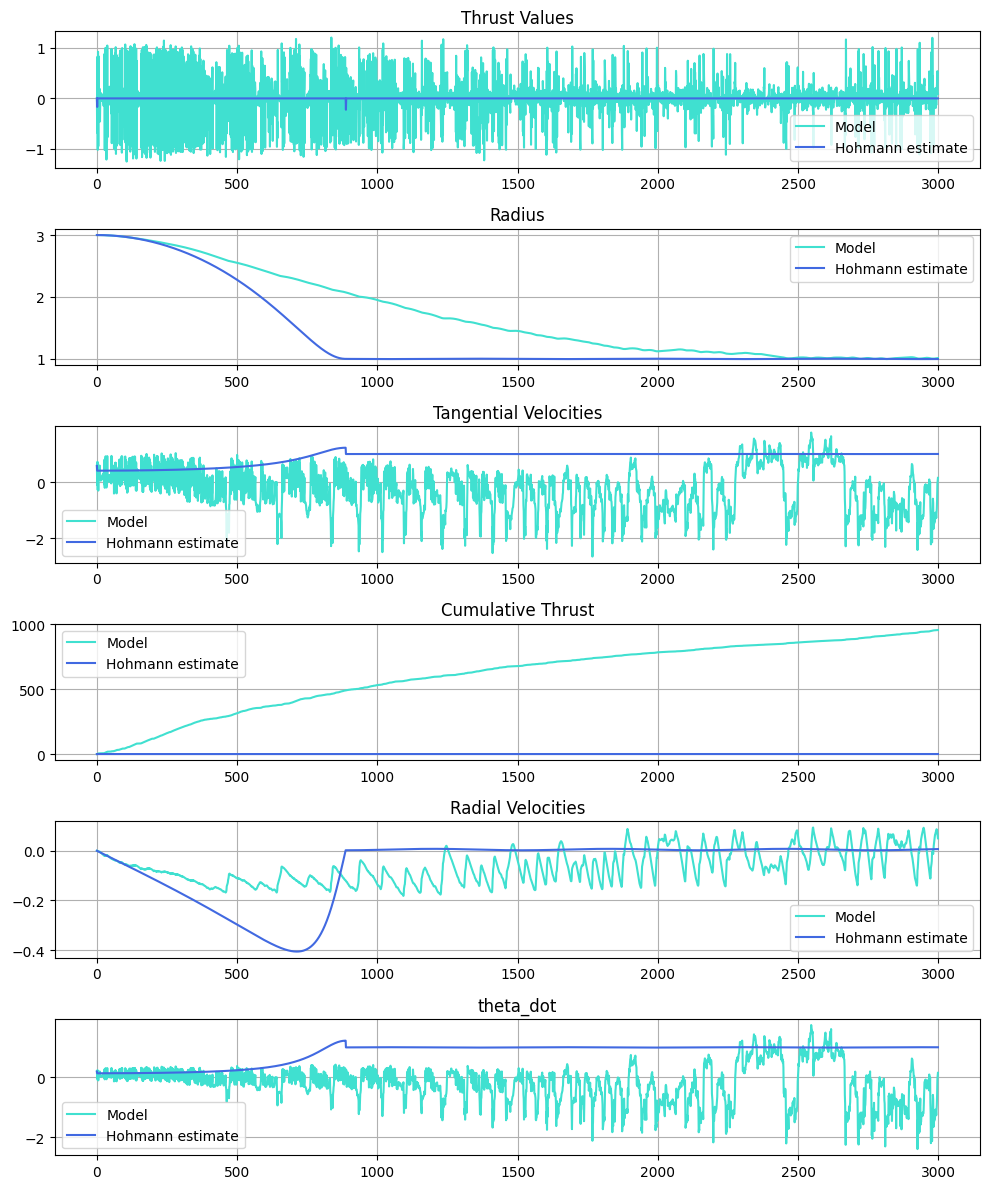

ETA: 21:24:44


CalledProcessError: Command '['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '800x800', '-pix_fmt', 'rgba', '-r', '10.0', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-y', 'test.mp4']' returned non-zero exit status 255.

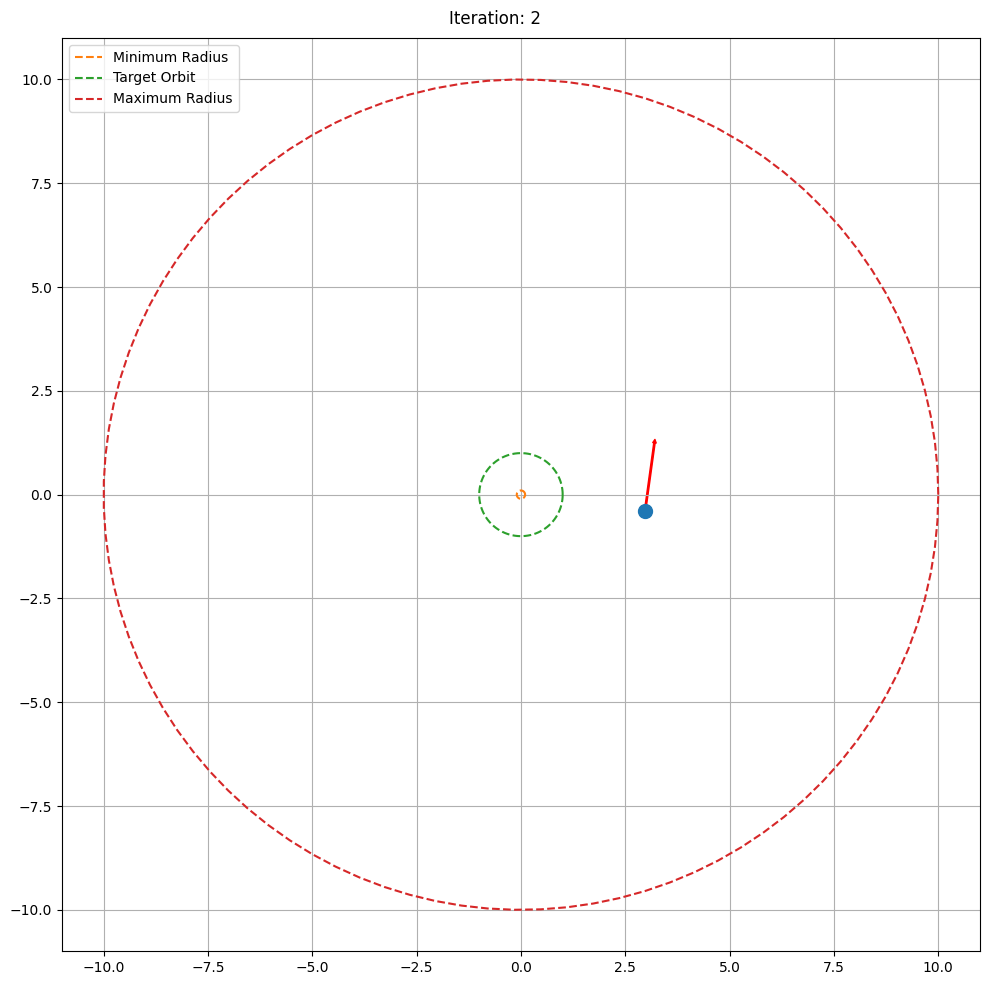

In [16]:
############## TRAINING MODEL CHANGES####################
gamma = 0.9999
lr_actor = 1e-3
lr_critic = 2e-3
rmin = 0.1
rmax = 10.0
mode = "Ln"
w_t = 0.1 # With act=1, -0.1 reward
w_r = 0.1 # At r=4.0, -0.3 reward
w_p = 0.01
w_c = 0.00003
max_training_timesteps = 40_000_000
max_steps, max_thrust, dt = 25_000, 100, 0.01

r_init = 3.0
r_target = 1.0

def make(name):
    init_func = orbit(r_init)
    return RocketEnv(max_step=max_steps, simulation_step=1, rmax=rmax, rmin=rmin,
            w_r = w_r , w_p = w_p, w_t = w_t, mode = "Ln", init_func=init_func,
            max_thrust=max_thrust, oob_penalty=0, dt=dt)

env = make('RocketCircularization-v1')
env.seed()
env = CTangentialThrust(PolarizeObservation(env))

done_one = False
done_two = False
def get_hohmann_delta_v(GM, r_end, r_init, state, done_one, done_two):
    # are we within 0.005 radius of optimal point?
    by_r_init = np.clip(-np.log(200*np.abs(state[0]-r_init)), 0, 1) > 0
    by_r_end = np.clip(-np.log(200*np.abs(state[0]-1)), 0, 1) > 0
    # output hohmann transfer ideal acceleration at that point then
    if by_r_init and not done_one:
        return 0, math.sqrt(GM / r_init) * (math.sqrt(2 * r_end / (r_init + r_end)) - 1), True, done_two # delta v needed at r_init
    elif by_r_end and not done_two:
        return 1, math.sqrt(GM / r_end) * (1 - math.sqrt(2 * r_init / (r_init + r_end))), done_one, True # delta v needed at r_end
    elif by_r_end and done_two:
        return 3, 0, done_one, done_two
    else:
        return 2, 0, done_one, done_two

ppo_agent = PPO(8, 1, 1e-3, 2e-3, 0.9999, 80, 0.2, True, 0.1)
ppo_agent.load('/content/hohmann9.pth')

state = env.reset()
r_init = state[0]
idx, needed_delta_v, done_one, done_two = get_hohmann_delta_v(1, 1.0, r_init, state, done_one, done_two)
phase = [needed_delta_v if i == idx else 0 for i in range(4)]
state = np.append(state, phase)
state[0] = np.sqrt(state[0])
state = np.append(state, state[2]*state[0])

max_len = 3_000
done = False
i = 0
while not done:
    env.render()
    action = ppo_agent.select_action(state, 1, -1)
    state, reward, done, ep_done, _ = env.step(action)
    idx, needed_delta_v, done_one, done_two = get_hohmann_delta_v(1, 1.0, r_init, state, done_one, done_two)
    phase = [needed_delta_v if i == idx else 0 for i in range(4)]
    state = np.append(state, phase)
    state[0] = np.sqrt(state[0])
    state = np.append(state, state[2]*state[0])

    i += 1
    done = done or i == max_len

print(i)
env2 = get_plots(env, r_init, r_target, max_len, max_steps, rmax, rmin, w_r, w_p, w_t, max_thrust, dt, True)

current_time = datetime.now()
t1 = current_time + timedelta(minutes=max_len*0.0072) - timedelta(hours=4)
print(f"ETA: {t1.strftime('%H:%M:%S')}")
env.show(path='test.mp4')
show_video('test.mp4')

/usr/local/lib/python3.10/dist-packages/gym/spaces/box.py:128: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
<ipython-input-25-d437436c2307>:32: RuntimeWarning: divide by zero encountered in log
  by_r_init = np.clip(-np.log(200*np.abs(state[0]-r_init)), 0, 1) > 0
<ipython-input-25-d437436c2307>:33: RuntimeWarning: divide by zero encountered in log
  by_r_end = np.clip(-np.log(200*np.abs(s

Streaming output truncated to the last 5000 lines.
20001
20002
20003
20004
20005
20006
20007
20008
20009
20010
20011
20012
20013
20014
20015
20016
20017
20018
20019
20020
20021
20022
20023
20024
20025
20026
20027
20028
20029
20030
20031
20032
20033
20034
20035
20036
20037
20038
20039
20040
20041
20042
20043
20044
20045
20046
20047
20048
20049
20050
20051
20052
20053
20054
20055
20056
20057
20058
20059
20060
20061
20062
20063
20064
20065
20066
20067
20068
20069
20070
20071
20072
20073
20074
20075
20076
20077
20078
20079
20080
20081
20082
20083
20084
20085
20086
20087
20088
20089
20090
20091
20092
20093
20094
20095
20096
20097
20098
20099
20100
20101
20102
20103
20104
20105
20106
20107
20108
20109
20110
20111
20112
20113
20114
20115
20116
20117
20118
20119
20120
20121
20122
20123
20124
20125
20126
20127
20128
20129
20130
20131
20132
20133
20134
20135
20136
20137
20138
20139
20140
20141
20142
20143
20144
20145
20146
20147
20148
20149
20150
20151
20152
20153
20154
20155
20156
20157
20158
2

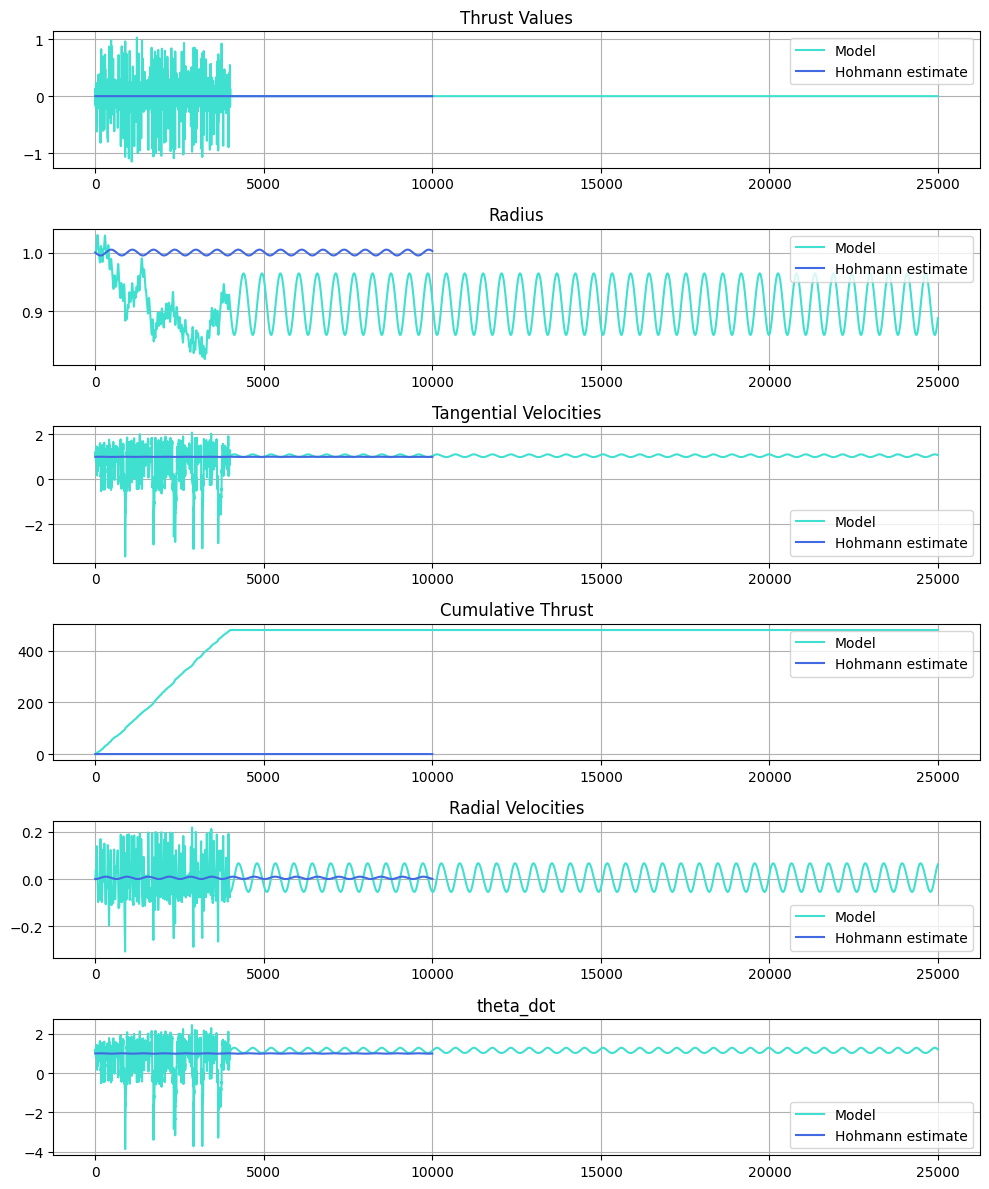

ETA: 00:21:36


CalledProcessError: Command '['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '800x800', '-pix_fmt', 'rgba', '-r', '10.0', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-y', 'test.mp4']' returned non-zero exit status 255.

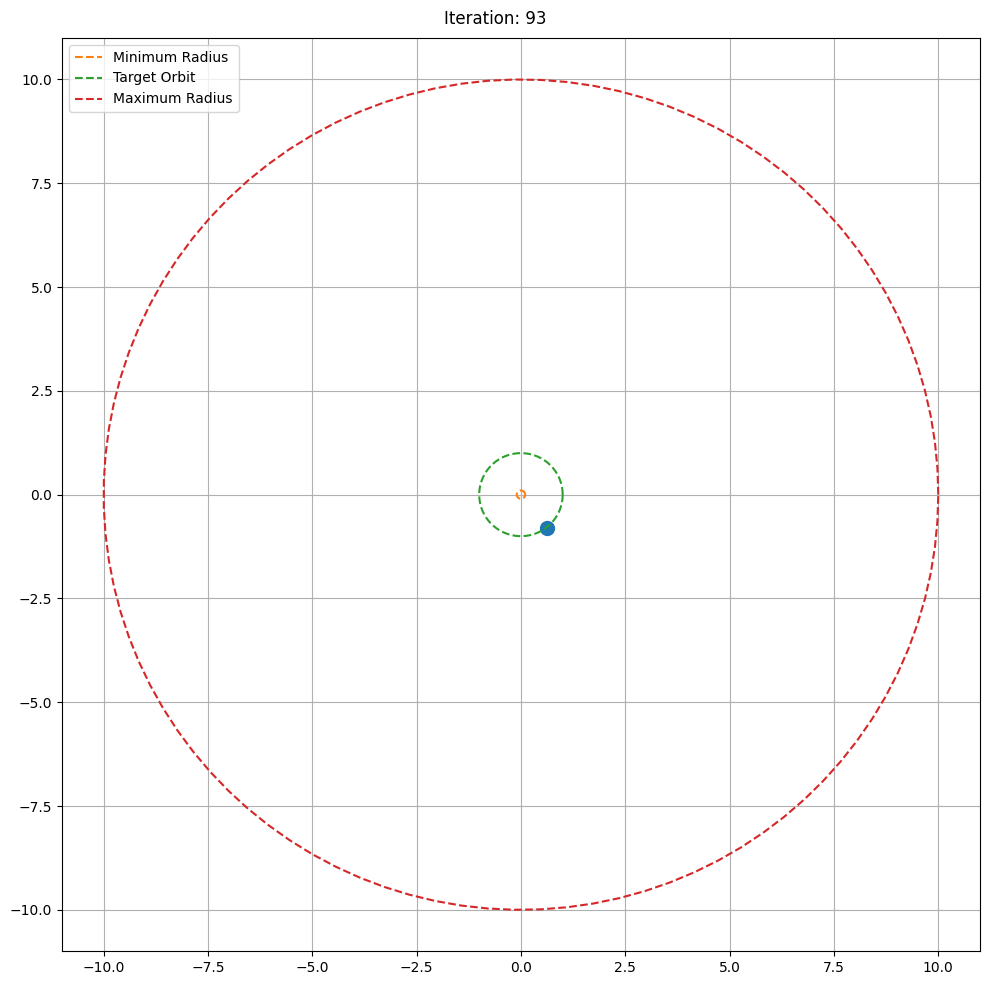

In [25]:
############## TRAINING MODEL CHANGES####################
gamma = 0.9999
lr_actor = 1e-3
lr_critic = 2e-3
rmin = 0.1
rmax = 10.0
mode = "Ln"
w_t = 0.1 # With act=1, -0.1 reward
w_r = 0.1 # At r=4.0, -0.3 reward
w_p = 0.01
w_c = 0.00003
max_training_timesteps = 40_000_000
max_steps, max_thrust, dt = 25_000, 100, 0.01

r_init = 1.0
r_target = 1.0

def make(name):
    init_func = orbit(r_init)
    return RocketEnv(max_step=max_steps, simulation_step=1, rmax=rmax, rmin=rmin,
            w_r = w_r , w_p = w_p, w_t = w_t, mode = "Ln", init_func=init_func,
            max_thrust=max_thrust, oob_penalty=0, dt=dt)

env = make('RocketCircularization-v1')
env.seed()
env = CTangentialThrust(PolarizeObservation(env))

done_one = False
done_two = False
def get_hohmann_delta_v(GM, r_end, r_init, state, done_one, done_two):
    # are we within 0.005 radius of optimal point?
    by_r_init = np.clip(-np.log(200*np.abs(state[0]-r_init)), 0, 1) > 0
    by_r_end = np.clip(-np.log(200*np.abs(state[0]-1)), 0, 1) > 0
    # output hohmann transfer ideal acceleration at that point then
    if by_r_init and not done_one:
        return 0, math.sqrt(GM / r_init) * (math.sqrt(2 * r_end / (r_init + r_end)) - 1), True, done_two # delta v needed at r_init
    elif by_r_end and not done_two:
        return 1, math.sqrt(GM / r_end) * (1 - math.sqrt(2 * r_init / (r_init + r_end))), done_one, True # delta v needed at r_end
    elif by_r_end and done_two:
        return 3, 0, done_one, done_two
    else:
        return 2, 0, done_one, done_two

ppo_agent = PPO(8, 1, 1e-3, 2e-3, 0.9999, 80, 0.2, True, 0.1)
ppo_agent.load('/content/hohmann11.pth')

state = env.reset()
r_init = state[0]
idx, needed_delta_v, done_one, done_two = get_hohmann_delta_v(1, 1.0, r_init, state, done_one, done_two)
phase = [needed_delta_v if i == idx else 0 for i in range(4)]
state = np.append(state, phase)
state[0] = np.sqrt(state[0])
state = np.append(state, state[2]*state[0])

max_len = 10_000
done = False
i = 0
while not done:
    env.render()
    action = ppo_agent.select_action(state, 1, -1)
    state, reward, done, ep_done, _ = env.step(action)
    done = done or ep_done

    idx, needed_delta_v, done_one, done_two = get_hohmann_delta_v(1, 1.0, r_init, state, done_one, done_two)
    phase = [needed_delta_v if i == idx else 0 for i in range(4)]
    state = np.append(state, phase)
    state[0] = np.sqrt(state[0])
    state = np.append(state, state[2]*state[0])

    if i == 4_000:
        while i <= max_steps and not done:
            env.render()
            s, r, d, e, _ = env.step(torch.tensor([0]))
            done = done or d or e
            reward += r
            i += 1

    i += 1
    done = done or i == max_steps

print(i)
env2 = get_plots(env, r_init, r_target, max_len, max_steps, rmax, rmin, w_r, w_p, w_t, max_thrust, dt, True)

current_time = datetime.now()
t1 = current_time + timedelta(minutes=max_len*0.0072) - timedelta(hours=4)
print(f"ETA: {t1.strftime('%H:%M:%S')}")
env.show(path='test.mp4')
show_video('test.mp4')

/usr/local/lib/python3.10/dist-packages/gym/spaces/box.py:128: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
<ipython-input-18-f246b7bb5cd4>:155: RuntimeWarning: divide by zero encountered in log
  by_r_init = np.clip(-np.log(200*np.abs(state[0]-r_init)), 0, 1) > 0


3000


<ipython-input-8-21db84be12fa>:679: RuntimeWarning: divide by zero encountered in log
  return np.clip(-np.log(value),min,max)


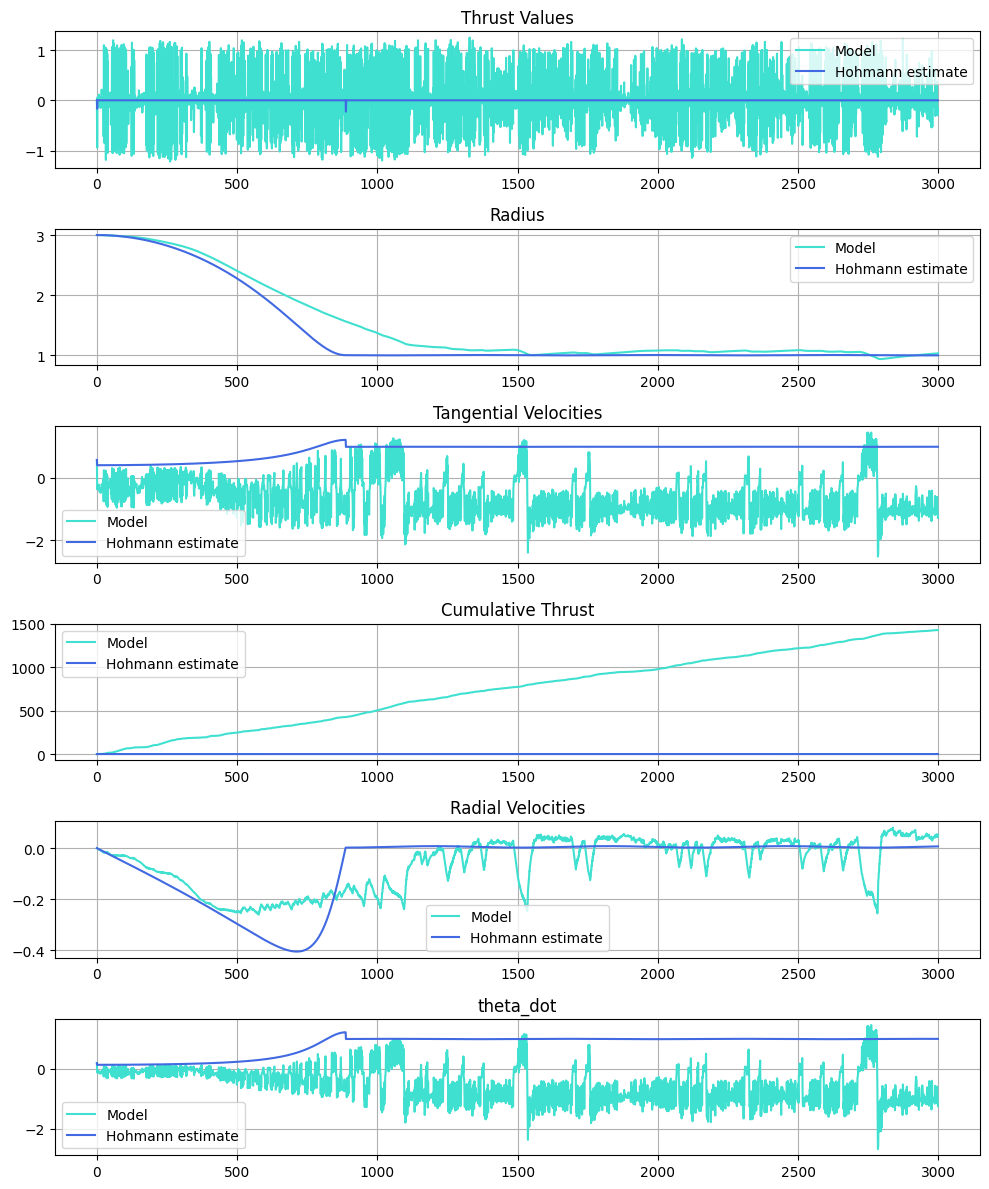

ETA: 21:25:15


CalledProcessError: Command '['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '800x800', '-pix_fmt', 'rgba', '-r', '10.0', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-y', 'test.mp4']' returned non-zero exit status 255.

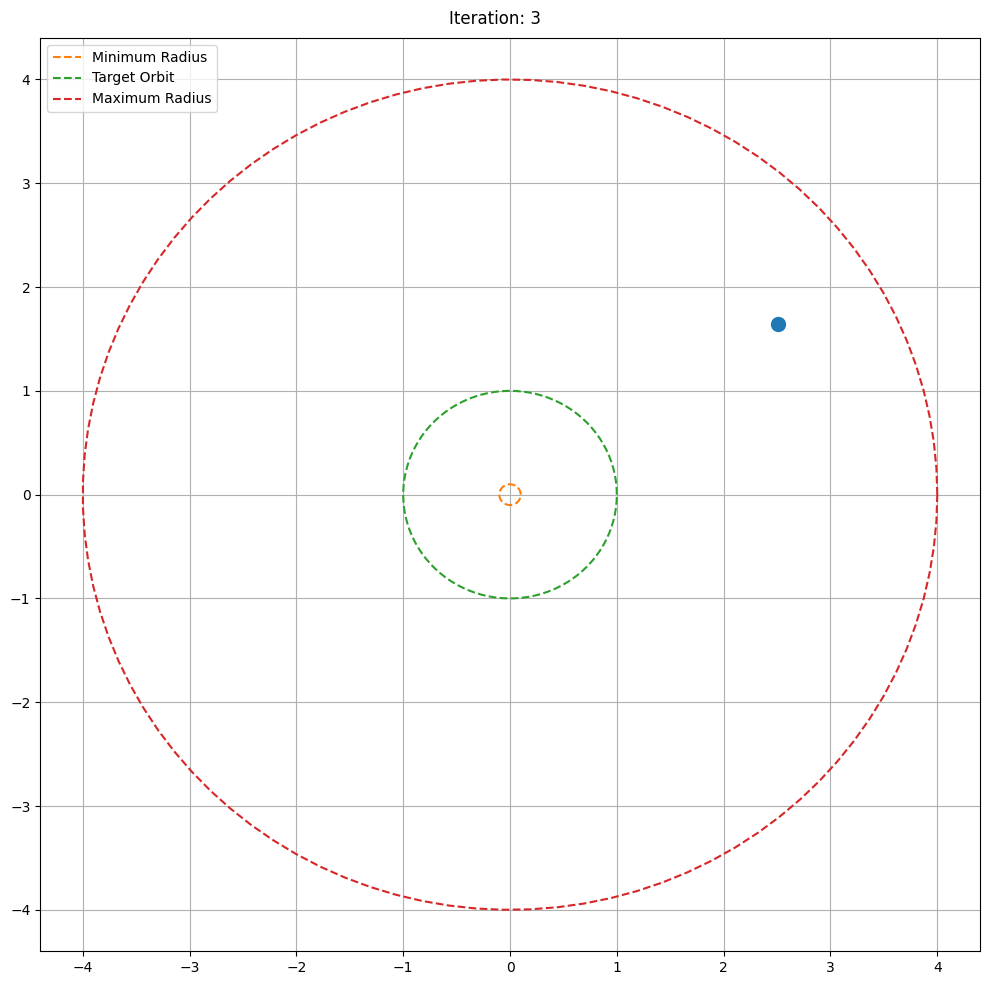

In [18]:
class Power7(Function):
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        return input ** 7

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        grad_input = grad_output * 7 * (input ** 6)
        return grad_input

class Power7Module(nn.Module):
    def forward(self, input):
        return Power7.apply(input)

class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim, has_continuous_action_space, action_std_init):
        super(ActorCritic, self).__init__()
        #In this section I'm only interested in the continous space
        self.has_continuous_action_space = has_continuous_action_space

        if has_continuous_action_space:
            self.action_dim = action_dim
            self.action_var = torch.full((action_dim,), action_std_init * action_std_init).to(device)

        # actor
        #I'm mainly going to keep the same dimensions as the ones used above
        if has_continuous_action_space :
            self.actor = nn.Sequential(
                            nn.Linear(state_dim, 12),
                            nn.LeakyReLU(),
                            nn.Linear(12, 12),
                            nn.LeakyReLU(),
                            nn.Linear(12, 12),
                            nn.LeakyReLU(),
                            nn.Linear(12, 12),
                            nn.LeakyReLU(),
                            nn.Linear(12, action_dim),
                            nn.Tanh(),
                            Power7Module()
                        )
            #the use of tanh here maps the actions in the range -1 / 1.
        else:
            self.actor = nn.Sequential(
                            nn.Linear(state_dim, 12),
                            nn.LeakyReLU(),
                            nn.Linear(12, 12),
                            nn.LeakyReLU(),
                            nn.Linear(12, 12),
                            nn.LeakyReLU(),
                            nn.Linear(12, 12),
                            nn.Tanh(),
                            nn.Linear(12, action_dim),
                            nn.Softmax(dim=-1)
                        )
            # the use of softmax if it's not continous gives for each action, a probability associated.
        # critic
        self.critic = nn.Sequential(
                        nn.Linear(state_dim, 12),
                        nn.Tanh(),
                        nn.Linear(12, 12),
                        nn.Tanh(),
                        nn.Linear(12, 12),
                        nn.Tanh(),
                        nn.Linear(12, 12),
                        nn.Tanh(),
                        nn.Linear(12, 1)
                    )
        # The use of tanh as an activation function here prevents a gradient
        #explosion by keeping in between the layers the values between -1/1


    def set_action_std(self, new_action_std):
        if self.has_continuous_action_space:
            self.action_var = torch.full((self.action_dim,), new_action_std * new_action_std).to(device)


    # This function is used during the interaction phase, where the agent interacts with the environment to collect experiences.
    def act(self, state, min, max):
        # the continous action
        if self.has_continuous_action_space:
          #so the actor has as a purpose to give off the meand of the action explaining even more the use of tanh
            action_mean = self.actor(state)
            # so that's where we aff the varience to it
            cov_mat = torch.diag(self.action_var).unsqueeze(dim=0)
            # This creqtes the multivavariate normal distribution with the specified mean and cov_mat
            dist = MultivariateNormal(action_mean, cov_mat)
        else:
            action_probs = self.actor(state)
            dist = Categorical(action_probs)
        # It samples from the distribution the action
        action = dist.sample()
        #print("action before clamp",action)
        #action = torch.clip(action,min,max) #ensures that the action is between a specific range.
        #print("action after clamp", action)
        action_logprob = dist.log_prob(action)
        state_val = self.critic(state)

        return action.detach(), action_logprob.detach(), state_val.detach()

  # This function is used during the training phase
    def evaluate(self, state, action):

        if self.has_continuous_action_space:

            action_mean = self.actor(state)
            action_var = self.action_var.expand_as(action_mean)
            cov_mat = torch.diag_embed(action_var).to(device)
            dist = MultivariateNormal(action_mean, cov_mat)

            # For Single Action Environments.(which is our situation here)
            if self.action_dim == 1:
                action = action.reshape(-1, self.action_dim)
        else:
            action_probs = self.actor(state)
            dist = Categorical(action_probs)
        action_logprobs = dist.log_prob(action)
        dist_entropy = dist.entropy()
        state_values = self.critic(state)

        return action_logprobs, state_values, dist_entropy

############## TRAINING MODEL CHANGES####################
gamma = 0.9999
lr_actor = 1e-3
lr_critic = 2e-3
rmin = 0.1
rmax = 4.0
mode = "Ln"
w_t = 0.1 # With act=1, -0.1 reward
w_r = 0.1 # At r=4.0, -0.3 reward
w_p = 0.01
w_c = 0.00003
max_training_timesteps = 40_000_000
max_steps, max_thrust, dt = 25_000, 100, 0.01

r_init = 3.0
r_target = 1.0

def make(name):
    init_func = orbit(r_init)
    return RocketEnv(max_step=max_steps, simulation_step=1, rmax=rmax, rmin=rmin,
            w_r = w_r , w_p = w_p, w_t = w_t, mode = "Ln", init_func=init_func,
            max_thrust=max_thrust, oob_penalty=0, dt=dt)

env = make('RocketCircularization-v1')
env.seed()
env = CTangentialThrust(PolarizeObservation(env))

done_one = False
done_two = False
def get_hohmann_delta_v(GM, r_end, r_init, state, done_one, done_two):
    # are we within 0.005 radius of optimal point?
    by_r_init = np.clip(-np.log(200*np.abs(state[0]-r_init)), 0, 1) > 0
    by_r_end = np.clip(-np.log(200*np.abs(state[0]-1)), 0, 1) > 0
    # output hohmann transfer ideal acceleration at that point then
    if by_r_init and not done_one:
        return 0, math.sqrt(GM / r_init) * (math.sqrt(2 * r_end / (r_init + r_end)) - 1), True, done_two # delta v needed at r_init
    elif by_r_end and not done_two:
        return 1, math.sqrt(GM / r_end) * (1 - math.sqrt(2 * r_init / (r_init + r_end))), done_one, True # delta v needed at r_end
    elif by_r_end and done_two:
        return 3, 0, done_one, done_two
    else:
        return 2, 0, done_one, done_two

ppo_agent = PPO(8, 1, 1e-3, 2e-3, 0.9999, 80, 0.2, True, 0.1)
ppo_agent.load('/content/hohmann10.pth')

state = env.reset()
r_init = state[0]
idx, needed_delta_v, done_one, done_two = get_hohmann_delta_v(1, 1.0, r_init, state, done_one, done_two)
phase = [needed_delta_v if i == idx else 0 for i in range(4)]
state = np.append(state, phase)
state[0] = np.sqrt(state[0])
state = np.append(state, state[2]*state[0])

max_len = 3_000
done = False
i = 0
while not done:
    env.render()
    action = ppo_agent.select_action(state, 1, -1)
    state, reward, done, ep_done, _ = env.step(action)
    idx, needed_delta_v, done_one, done_two = get_hohmann_delta_v(1, 1.0, r_init, state, done_one, done_two)
    phase = [needed_delta_v if i == idx else 0 for i in range(4)]
    state = np.append(state, phase)
    state[0] = np.sqrt(state[0])
    state = np.append(state, state[2]*state[0])

    i += 1
    done = done or i == max_len

print(i)
env2 = get_plots(env, r_init, r_target, max_len, max_steps, rmax, rmin, w_r, w_p, w_t, max_thrust, dt, True)

current_time = datetime.now()
t1 = current_time + timedelta(minutes=max_len*0.0072) - timedelta(hours=4)
print(f"ETA: {t1.strftime('%H:%M:%S')}")
env.show(path='test.mp4')
show_video('test.mp4')